<a href="https://colab.research.google.com/github/triablomanon/MSE233/blob/HW2/MSE233_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1. Solving Games with Best-Response Oracles

Suppose you have a zero sum game where the minimizing player has a set $I$ of $n$ actions and the maximizing player has a potentially infinte set of actions $J$. We assume, there exists a function $A(i,j)$ that for each action $i$ of the min player and each action $j$ of the max player, returns a scalar loss.

More, broadly for any distribution $x$ over $I$ and every distribution $y$ over $J$, we have:
\begin{align}
\ell(x, y) = E_{i\sim x, j\sim y}[A(i,j)]
\end{align}
We can think of the above as having a matrix $A$ with infinitely many columns. We will also denote with $A_j$ the $j$-th column of this matrix, i.e. the vector $A_j=(A(1,j),\ldots, A(n,j))$. Then for any action $j\in J$ of the max player and any $x$ in the simplex $\Delta(n)$:
\begin{align}
\ell(x,y) = x^\top E_{j\sim y}[A_j]
\end{align}

We consider the zero-sum game defined by the min-max problem:
\begin{align}
\min_{x \in \Delta(n)} \max_{y\in \Delta(J)} \ell(x, y)
\end{align}
We want to calculate an approximate equilibrium $(\bar{x}, \bar{y})$, where $\bar{y}$ is a finitely supported mixture over the space of strategies of the max player.

We assume we have access to a best response oracle, that for any action $x$ of the min player, can solve the problem:
\begin{align}
\text{Oracle}(x) = \arg\max_{j\in J} E_{i\sim x}[A(i,j)] = \arg\max_{j\in J} x^\top A_j
\end{align}

We will also assume we have access to a loss vector oracle function, that when given an index $j$, it returns the loss vector $A_j$, i.e.
\begin{align}
\text{LossVector}(j) = A_j
\end{align}

Implement a procedure that calculates such an approximate equilibrium with access to the best response oracle and the loss vector oracle, using no-regret dynamics. No other property or structure of the underlying game is allowed to be used during the calculation.


Implement oracle based no-regret dynamics to compute an approximate equilibrium of the game. Use the approach where one player uses the Multiplicative Weight Updates (MWU) algorithm, while the other player best-responds to the first player at each period, invoking the best-response oracle.

In [3]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def get_oracle_functions(A):
    ''' Define and return the oracle functions: (1) minp_loss_vector
    and (2) best_response for the loss matrix A.
    '''
    def minp_loss_vector(j):
        '''(0.5 points)
        Returns the loss vector for each action of the min player, given
        the choice of action j of the max player.
        '''
        return A[:, j]


    def best_response(x):
        ''' (0.5 points)
        Returns the best response action for the max player, given
        the choice probabilities of the min player.
        '''
        return np.argmax(np.dot(x, A))

    return minp_loss_vector, best_response

In [4]:
###
# BELOW THIS PART YOU CAN ONLY USE the quantity `n` and the functions
# `minp_loss_vector`, `best_response`
# YOU CANNOT directly use the matrix `A` or the quantity `m`
###

def run_mwu_algorithm(minp_loss_vector, best_response, n, m):
    ''' (1 point)
    Run multiplicative weight updates to get the equillibrium response for x.
    Player y plays the best response action to x at each period.

    Inputs:
    minp_loss_vector, best_response: oracle functions
    n: number of actions for player x
    m: number of actions for player y
    '''
    # please don't change the value of constants T or eta -
    # this might lead to auto-grader marking your solution as incorrect!
    np.random.seed(42)
    # number of iterations of no-regret dynamics
    T = 10000
    # step size for exponential weights
    eta = 5/np.sqrt(T)
    # initialize to uniform probabilities over actions for the min player
    x = np.ones((T, n)) / n
    # initialize the choice of action for the max player
    ychoice = np.zeros((T,)).astype(int)

    for t in np.arange(1, T):

        # loss vector for x player, given last choice of action for the max player
        lx = minp_loss_vector(ychoice[t-1])

        # update probabilities for x player, based on Multiplicative Weight Updates
        x[t] = x[t-1] * np.exp(-eta * lx) / np.sum(x[t-1] * np.exp(-eta * lx))

        # choose next strategy for the max player as the best response to x[t]
        ychoice[t] = best_response(x[t])

    return (x, ychoice)

In [5]:
def calculate_equilibrium_strategy(x, ychoice):
    ''' (0.5 points)
    Calculate equilibrium given the time series array of choice probabilities
    as computed using run_mwu_algorithm.
    Inputs:
    x: choice probabilities for the min player for times 1 to T as computed using MWU
    y: best choice index for the max player for times 1 to T as computed using the best response oracle

    Return:
    Equillibrium strategy for x and y as a prob ability vector over the n and m simplex respectively.
    '''

    # equillibrium x is the average of all xs in the time series
    xbar = np.mean(x, axis = 0)

    # convert y indices to one hot vectors
    yohe = OneHotEncoder(sparse_output=False).fit_transform(ychoice.reshape(-1, 1))

    # calculate the average choice probabilities of the y player for each action
    ybar = np.mean(yohe, axis = 0)

    return (xbar, ybar)

In [6]:
def compute_regrets(xbar, ychoice, minp_loss_vector, best_response):
    ''' (1 point)
    Inputs:
    xbar: equillibrium startegy for the x player
    ychoice: array of choices made by the y player
    minp_loss_vector, best_response: oracle functions

    Returns:
    regret_min, regret_max: regret for the min and max players respectively
    '''

    xbar, ybar = calculate_equilibrium_strategy(x, ychoice)

    eq_loss_vector = np.zeros(len(xbar))
    for j in range(len(ybar)):
      if ybar[j] > 0:
        eq_loss_vector += ybar[j] * minp_loss_vector(j)

    # calculate the equilibrium loss
    # \ell(\bar{x}, \bar{y}) = \bar{x}^top E_{j\sim \bar{y}}[A_j]
    value = xbar @ eq_loss_vector

    # we calculate regret of the x-player at the computed equilibrium
    # calculate regret: ell(\bar{x}, \bar{y}) - min_x ell(x, \bar{y})
    regret_min = value - np.min(eq_loss_vector)

    # we calculate regret of the y-player at the computed equilibrium
    # calculate regret: max_{j\in J} ell(\bar{x}, j) - ell(\bar{x}, \bar{y})
    regret_max = xbar @ minp_loss_vector(best_response(xbar)) - xbar @ eq_loss_vector

    return regret_min, regret_max

In [7]:
# define zero sum game with potentially huge number of columns min_x max_y x'Ay
# for simplicity here we just use a small game as an example, for illustration
# purposes
A = np.array([[1, 0], [0, 2]])
# get number of actions for each player
n, m = A.shape

# get the oracle functions
minp_loss_vector, best_response = get_oracle_functions(A)

# run multiplicative weights algorithm to generate a series of strategies
# for time steps from t = 1 to T
x, ychoice = run_mwu_algorithm(minp_loss_vector, best_response, n, m)

# compute the equillibrium strategy for both min and max player
xbar, ybar = calculate_equilibrium_strategy(x, ychoice)
print(xbar, ybar)

# compute the regret for the max and min players
regret_min, regret_max = compute_regrets(xbar, ychoice, minp_loss_vector, best_response)
print(regret_min, regret_max)

[0.66803424 0.33196576] [0.6662 0.3338]
0.0004647520670769678 0.0013694857518009584


Expected Answer (very small precision errors are okay): \\
xbar, ybar =  [0.66803424 0.33196576] [0.6662 0.3338]
regret_min, regret_max = 0.0004647520670769678 0.0013694857518009584

# Problem 2. Boosting with AdaBoost

Use the approach you developed in the previous problem and modify it so as to implement the boosting algorithm. In Boosting we are given a data set of $n$ samples $(W_1, c_1),...,(W_n,c_n)$, where $W\in R^d$ are covariates, drawn each i.i.d. from some distribution $D$ and $c_i\in \{0,1\}$ are binary class labels associated with these covariates. Our goal is to learn a function $h$ that accurately predicts the true label, i.e.
\begin{align}
h(W_i) = c_i
\end{align}
We want to learn a hypothesis $h$ that minimizes the probability of error, i.e.
\begin{align}
\frac{1}{n} \sum_{i=1}^n 1\{h(W_i) \neq c_i\}
\end{align}
Under further analysis this will also imply $\Pr_{W\sim D}[h(W)\neq c_i]$ is small, which is what we truly care about. However, in this exercise we mostly care about achieving small training error.

We assume that we are given access to an oracle function $\text{oracle}(x)$ that takes as input any distribution over the empirical samples $x$ and returns a hypothesis $h$ in some space $H$ of base hypothesis that has average accuracy at least $1/2+\delta$, i.e.
\begin{align}
\sum_{i=1}^n x_i 1\{h(W_i) = c_i\} \geq 1/2+\delta
\end{align}

We want to use this oracle algorithm as a black-box and construct a new hypothesis $\bar{h}$ (which can be an ensemble or a distribution over the base hypotheses) that classifies correctly all the empirical samples, i.e.
\begin{align}
\frac{1}{n} \sum_{i=1}^n 1\{h(W_i) =c_i\} = 1
\end{align}


The above problem can be reduced to solving a zero-sum game with a best-response oracle. Note that our goal is to find a mixture (or distribution) of base hypotheses $P$ that classifies accurately all samples. Hence, we will look for a mixture of hypotheses that maximizes the worst case accuracy over any sample
\begin{align}
\max_{h\sim P} \min_{i} E_{h\sim P}[1\{h(W_i) = c_i\}]
\end{align}
We can also think of the internal minimizing player as the adversary and the external maximizing player as the learner. The adversary is also allowed without loss of generality to choose distributions over samples $x=(x_1,\ldots,x_n)$. Hence, we arrive at the zero-sum game defined by the max-min problem:
\begin{align}
\max_{h\sim P} \min_{x\in \Delta(n)} \sum_{i=1}^n x_i E_{h\sim P}[1\{h(W_i) = c_i\}]
\end{align}
where $\Delta(n)$ is the simplex in $n$ dimensions. By the min-max duality, we can view this as the zero-sum game associated with the min-max problem:
\begin{align}
\min_{x\in \Delta(n)} \max_{h\sim P}  \sum_{i=1}^n x_i E_{h\sim P}[1\{h(W_i) = c_i\}]
\end{align}

This problem now fits the setting of the previous problem. The min player (adversary) has a finite set $I$ of $n$ actions, corresponding to the samples and chooses a weight for each sample. The max player (learner) has a potentially infinite set of actions $H$, corresponding to the base hypotheses.

For any choice $h$ of the max player (learner) and any choice $i\in I$ of the min player (adversary) the loss is defined as:
\begin{align}
1\{h(W_i) =c_i\}
\end{align}
and for any distribution $x$ of the adversary and distribution $P$ of the learner, the expected loss is:
\begin{align}
\ell(x, P) = E_{i\sim x, h\sim P}[1\{h(W_i) =c_i\}]
\end{align}
Moreover, we have a best-response oracle for the max player, which given any distribution $x$ over the samples, returns a base hypothesis $h\in H$, which satisfies:
\begin{align}
E_{i\sim x}[1\{h(W_i) =c_i\}] \geq 1/2 + \delta
\end{align}
Even though the oracle is not guaranteed to return the best $h$ that maximizes the accuracy for $x$, it turns out that choosing an $h$ that satisfies the above "weak learning" property is good enough. We will solve for the equilibrium of this game using this weak best response oracle as if it was a best-response oracle.

By the weak learning guarantee we know that:
\begin{align}
\min_{x\in \Delta(n)} \max_{h\in H} E_{i\sim x}[1\{h(W_i)=c_i\}] \geq 1/2 +\delta
\end{align}
Thus the value of the game is at least $1/2+\epsilon$ and therefore by the minimax duality we also get:
\begin{align}
\max_{P} \min_{i \in [n]} E_{h\sim P}[1\{h(W_i)=c_i\}] \geq 1/2 + \delta
\end{align}
Thus we get that there must exist a distribution $P$, the majority of the base hypothesis in the distribution get every sample classified accurately. Hence, if we return as $\bar{h}$ to be the majority vote of the base hypotheses in $P$, we will be classifying every sample correctly.

## Problem 2.2

Implement this approach to boosting (typically known as AdaBoost). Fill in the details in the cells below, whenever missing.

First we will simply generate the training data as well as a set of validation data to measure out of sample performance of the hypothesis.

In [8]:
def true_label(w):
    ''' The true classification function for labeling datapoint w'''
    return (w[:, 0] < 0.2) | (w[:, 0] > 0.8)

def generate_data(true_label, nfeatures=1, nsamples=100):
    ''' Data generation function'''
    # we generate fake training data with nsamples and nfeatures
    # all covariates are binary for simplicity
    W = np.random.uniform(0, 1, size=(nsamples, nfeatures))
    label = true_label(W)

    # we also generate fake evaluation data to measure accuracy out of sample
    Wval = np.random.uniform(0, 1, size=(10000, nfeatures))
    label_val = true_label(Wval)

    return {'W': W, 'label':label, 'Wval': Wval, 'label_val': label_val}

np.random.seed(123)
data = generate_data(true_label)
W = data['W']
label = data['label']
Wval = data['Wval']
label_val = data['label_val']

We will be using a simple depth-1 binary decision tree classifier as our base hypothesis. We can find a good such base classifier using scikit-learn's implementation of binary decision trees.

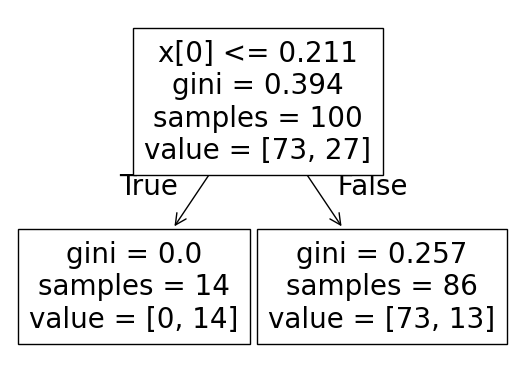

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Fit a very simple depth 1 decision tree to classify
clf = DecisionTreeClassifier(max_depth=1, random_state=42)
clf.fit(W, label)

# visualize the tree
plot_tree(clf)
plt.show()

Your tree should look like this: 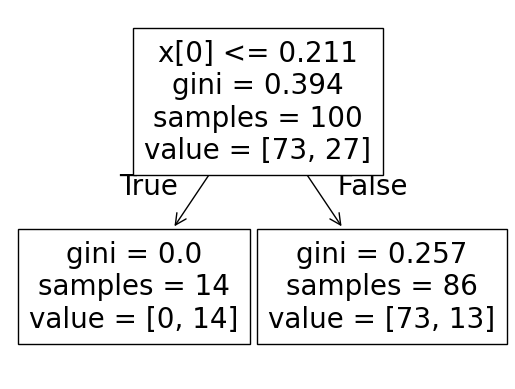

We see that the performance of the depth-1 decision tree is far from perfect, even on the training data.

In [10]:
# accuracy on the training data
np.mean(clf.predict(W) == label)

np.float64(0.87)

In [11]:
# accuracy on the validation data
np.mean(clf.predict(Wval) == label_val)

np.float64(0.7941)

We will boost the performance, using the scikit-learn decision tree method as our weak learning oracle.

In [12]:
# Boosting as oracle-based best response dynamics
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def get_oracle_functions_boosting(W, label):
    ''' Define and return the oracle functions
    Inputs: W (training covariates), label (training labels)
    Returns: minp_loss_vector, best_response
    '''
    def minp_loss_vector_boosting(h):
        '''(1 point)
        Returns the loss vector for each action of the min player (adversary),
        given the choice of action h of the min player. Here the actions of the
        min player are the samples. So we need to report the loss of h on each
        of the n samples. The min player is trying to weight the samples so as to
        make the hypothesis as in-accurate as possible. Hence, the loss that it
        is minimizing is simply the zero-one accuracy of the hypothesis on the
        sample, i.e. whether the hypothesis h predicts the sample correctly or not.
        '''
        return (h.predict(W) == label).astype(int)

    def best_response_boosting(x):
        ''' (1 point)
        Returns the best response action for the max player (learner), given
        the choice probabilities of the min player. The max player is trying to
        make the hypothesis as accurate as possible on the weighted samples.
        Hence, the loss is the weighted zero-one loss and we return a classifier
        that is trained on this weighted zero-one loss. We will return the trained
        DecisionTreeClassifier object that corresponds to the best response to the
        sample weights `x`.
        '''
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(W, label, sample_weight=x)
        return clf

    return minp_loss_vector_boosting, best_response_boosting

In [13]:
# getting the oracle functions
minp_loss_vector_boosting, best_response_boosting = get_oracle_functions_boosting(W, label)

In [14]:
def run_mwu_algorithm_boosting(minp_loss_vector_boosting, best_response_boosting, W):
    ''' (.5 point)
    Run multiplicative weight updates to get the equillibrium response for x.
    Player y plays the best response action to x at each period.

    Inputs:
    minp_loss_vector_boosting, best_response_boosting: oracle functions
    W: data
    '''
    np.random.seed(42)
    # number of iterations of no-regret dynamics
    T = 100
    # step size for exponential weights
    eta = 5/np.sqrt(T)
    # initialize uniform probabilities over actions for the min player (adversary)
    # this is a uniform distribution over the samples
    n = W.shape[0]
    x = np.ones((T, n)) / n
    # initialize the choice of action for the max player (learner)
    # the actions of the max player are decision tree classifiers
    learner_trees = [best_response_boosting(x[0])]
    for t in np.arange(1, T):

        # loss vector for x player, given last choice of action for the max player
        lx = minp_loss_vector_boosting(learner_trees[-1])

        # update probabilities for x player, based on Multiplicative Weight Updates
        x[t] = x[t-1]*np.exp(-eta*lx)
        x[t] = x[t]/np.sum(x[t])

        # choose next strategy for the max player as the best response to x[t]
        # and append it to the list `learner_trees`
        clf = best_response_boosting(x[t])
        learner_trees.append(clf)

    return x, learner_trees

In [15]:
# run the multiplicative weights algorithm
x, learner_trees = run_mwu_algorithm_boosting(minp_loss_vector_boosting, best_response_boosting, W)

# the adversary equilibrium weights is the average of the weights
xbar = np.mean(x, axis=0)

In [22]:
# The learner equilibrium distribution is a mixture over the base classifiers
# Since our base classifiers are trees, this mixture will be a forest. We will
# be predicting based on the majority vote of the forest.

class Forest:

    def __init__(self, trees):
        self.trees = trees

    def predict_proba(self, W):
        ''' (0.5 points) '''
        # W is matrix where each row contains a sample W_i.
        # return a vector that contains the fraction of trees that predict 1
        # for each sample W_i contained in W (0.25 points)
        predict = np.array([tree.predict(W) for tree in self.trees])
        return np.mean(predict, axis=0)

    def predict(self, W):
        ''' (0.5 points) '''
        # W is matrix where each row contains a sample W_i.
        # returns a binary vector that indicates for each W_i contained in W,
        # whether the majority of the trees predict 1 or not (0.25 points)
        return self.predict_proba(W) > 0.5

In [23]:
# define the forest based on the learned trees
gbforest = Forest(learner_trees)

Now we observe that the boosted ensemble of trees (aka the Boosted Forest) achieves perfect classification accuracy on the training data and almost perfect on the validation data.

In [24]:
np.mean(gbforest.predict(W) == label)

np.float64(1.0)

In [25]:
np.mean(gbforest.predict(Wval) == label_val)

np.float64(0.9863)

Moreover, we should be seeing that the majority of the learners in the ensemble predict the correct label.

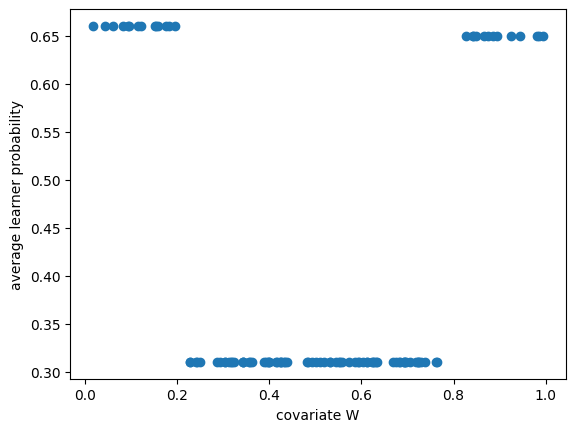

In [26]:
# We plot the average prediction of the ensemble of learners over time.
# This is the prediction probability of the equilibrium mixture of learners
# Ideally it should be above 0.5 whenever the true label is 1 and below 0.5
# when the true label is zero.
plt.scatter(W[:, 0], gbforest.predict_proba(W))
plt.xlabel('covariate W')
plt.ylabel('average learner probability')
plt.show()

Your image should look like this: 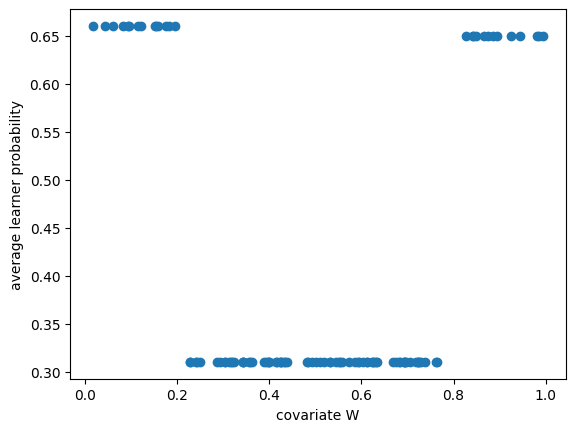

We can also calculate the regret of each player in the zero-sum game


In [31]:
def compute_regrets_boosting(xbar, learner_trees, minp_loss_vector, best_response):
    ''' (1 point) '''
    # The learner equilibrium distribution is a mixture over the base classifiers
    # i.e. \bar{P} = Uniform{h1, ...., hT}, where ht is the tree chosen by the
    # learner at the t-th period.
    # we calculate regret of the min player (adversary), given the distribution of
    # actions of the max player (learner)

    T = len(learner_trees)
    expected_loss_vector = sum(minp_loss_vector(tree) for tree in learner_trees)/T

    # calculate the equilibrium loss \ell(\bar{x}, \bar{P})
    value = xbar @ expected_loss_vector

    # calculate min player regret: ell(\bar{x}, \bar{P}) - min_x ell(x, \bar{P})
    regret_min = value - np.min(expected_loss_vector)

    # we calculate regret of the max player (learner), given the distribution of
    # actions of the min player (adversary)

    # calculate max player regret: max_h \ell(x, h) - ell(\bar{x}, \bar{P})
    regret_max = xbar @ minp_loss_vector(best_response(xbar)) - value

    return regret_min, regret_max

In [32]:
# let's call the function to compute the regret
regret_min, regret_max = compute_regrets_boosting(xbar, learner_trees, minp_loss_vector_boosting, best_response_boosting)
print(regret_min, regret_max)

0.016610493063258014 0.01704803577147762


Expected answer: \\
regret_min, regret_max = 0.016610493063258014 0.01704803577147762


We can also visualize the dynamics to understand how the procedure weights different samples and different parts of the covariate space as the number of boosting periods progresses.

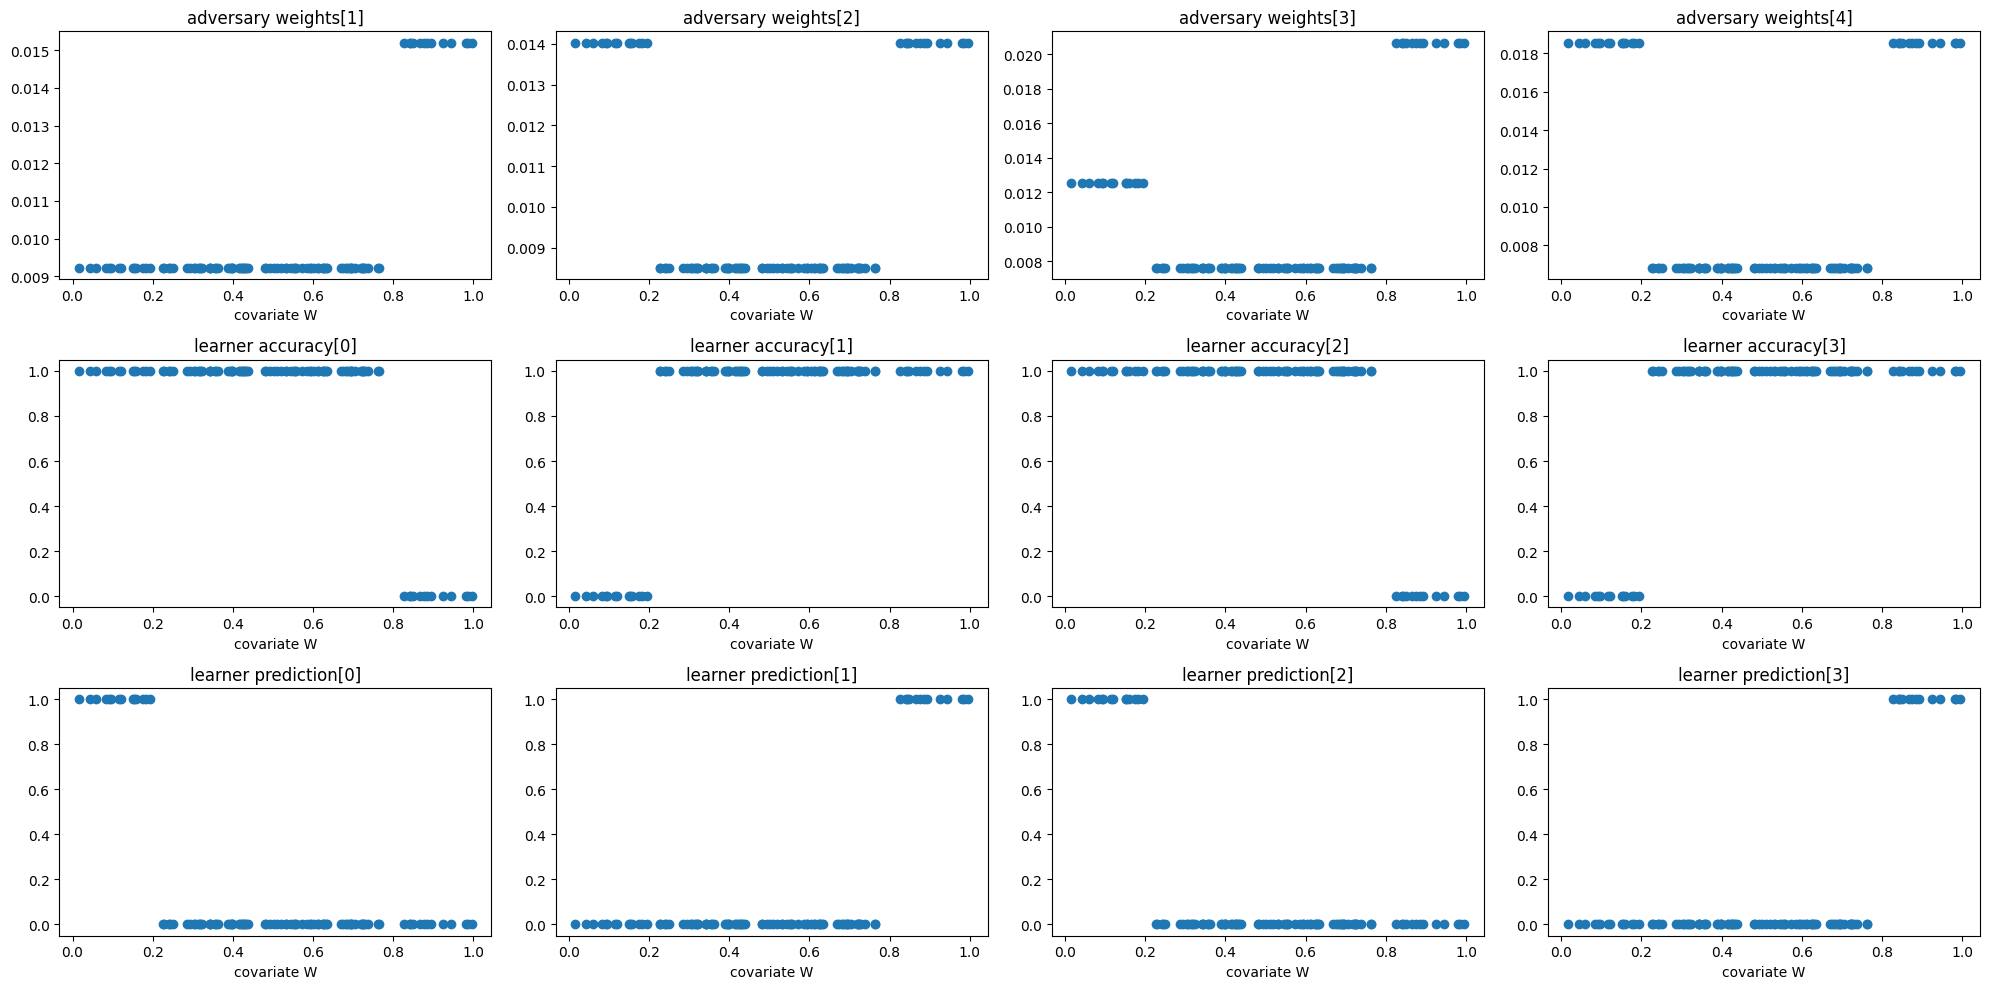

In [33]:
# We try to understand a bit the dynamics by plotting the weights of the
# adversary at each period and the accuracy of the learner chosen at the
# previous period. Ideally the adversary should be increasing the weight on
# mis-classified samples in the previous period.
plt.figure(figsize=(20, 10))
for t in np.arange(1, 5):
    plt.subplot(3, 4, t)
    plt.title(f"adversary weights[{t}]")
    plt.scatter(W[:, 0], x[t])
    plt.xlabel('covariate W')
    plt.subplot(3, 4, 4 + t)
    plt.title(f"learner accuracy[{t-1}]")
    plt.scatter(W[:, 0], learner_trees[t-1].predict(W)==label)
    plt.xlabel('covariate W')
    plt.subplot(3, 4, 8 + t)
    plt.title(f"learner prediction[{t-1}]")
    plt.scatter(W[:, 0], learner_trees[t-1].predict(W))
    plt.xlabel('covariate W')
plt.tight_layout()
plt.show()

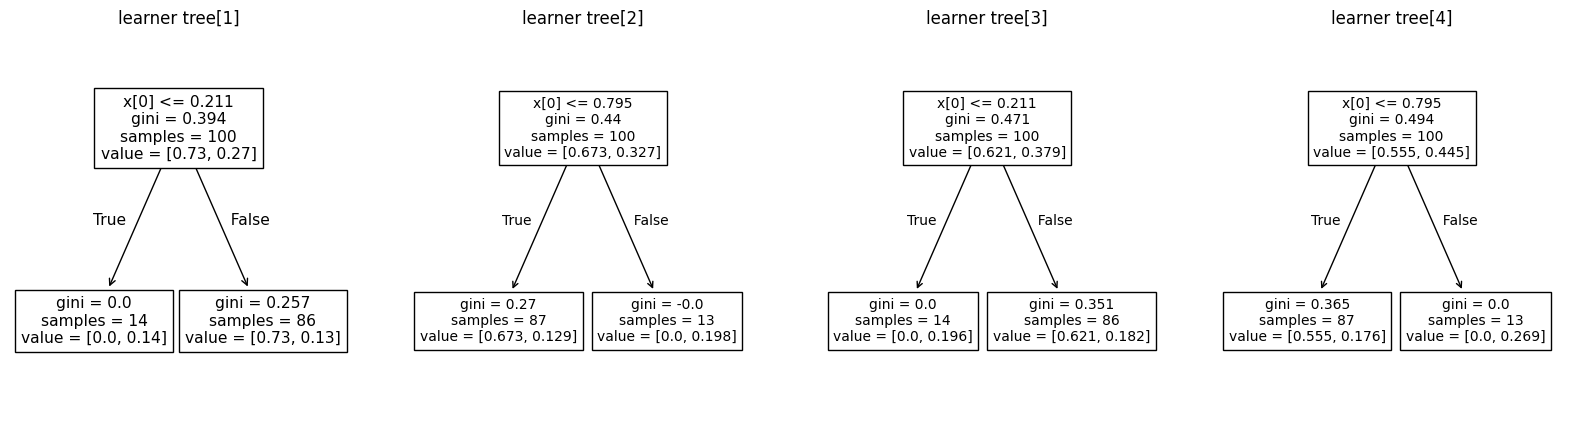

In [34]:
# We also visualize the trees of the learner at each period
plt.figure(figsize=(20, 5))
for t in np.arange(1, 5):
    plt.subplot(1, 4, t)
    plot_tree(learner_trees[t-1])
    plt.title(f"learner tree[{t}]")
plt.show()

Your images should look like this: \\
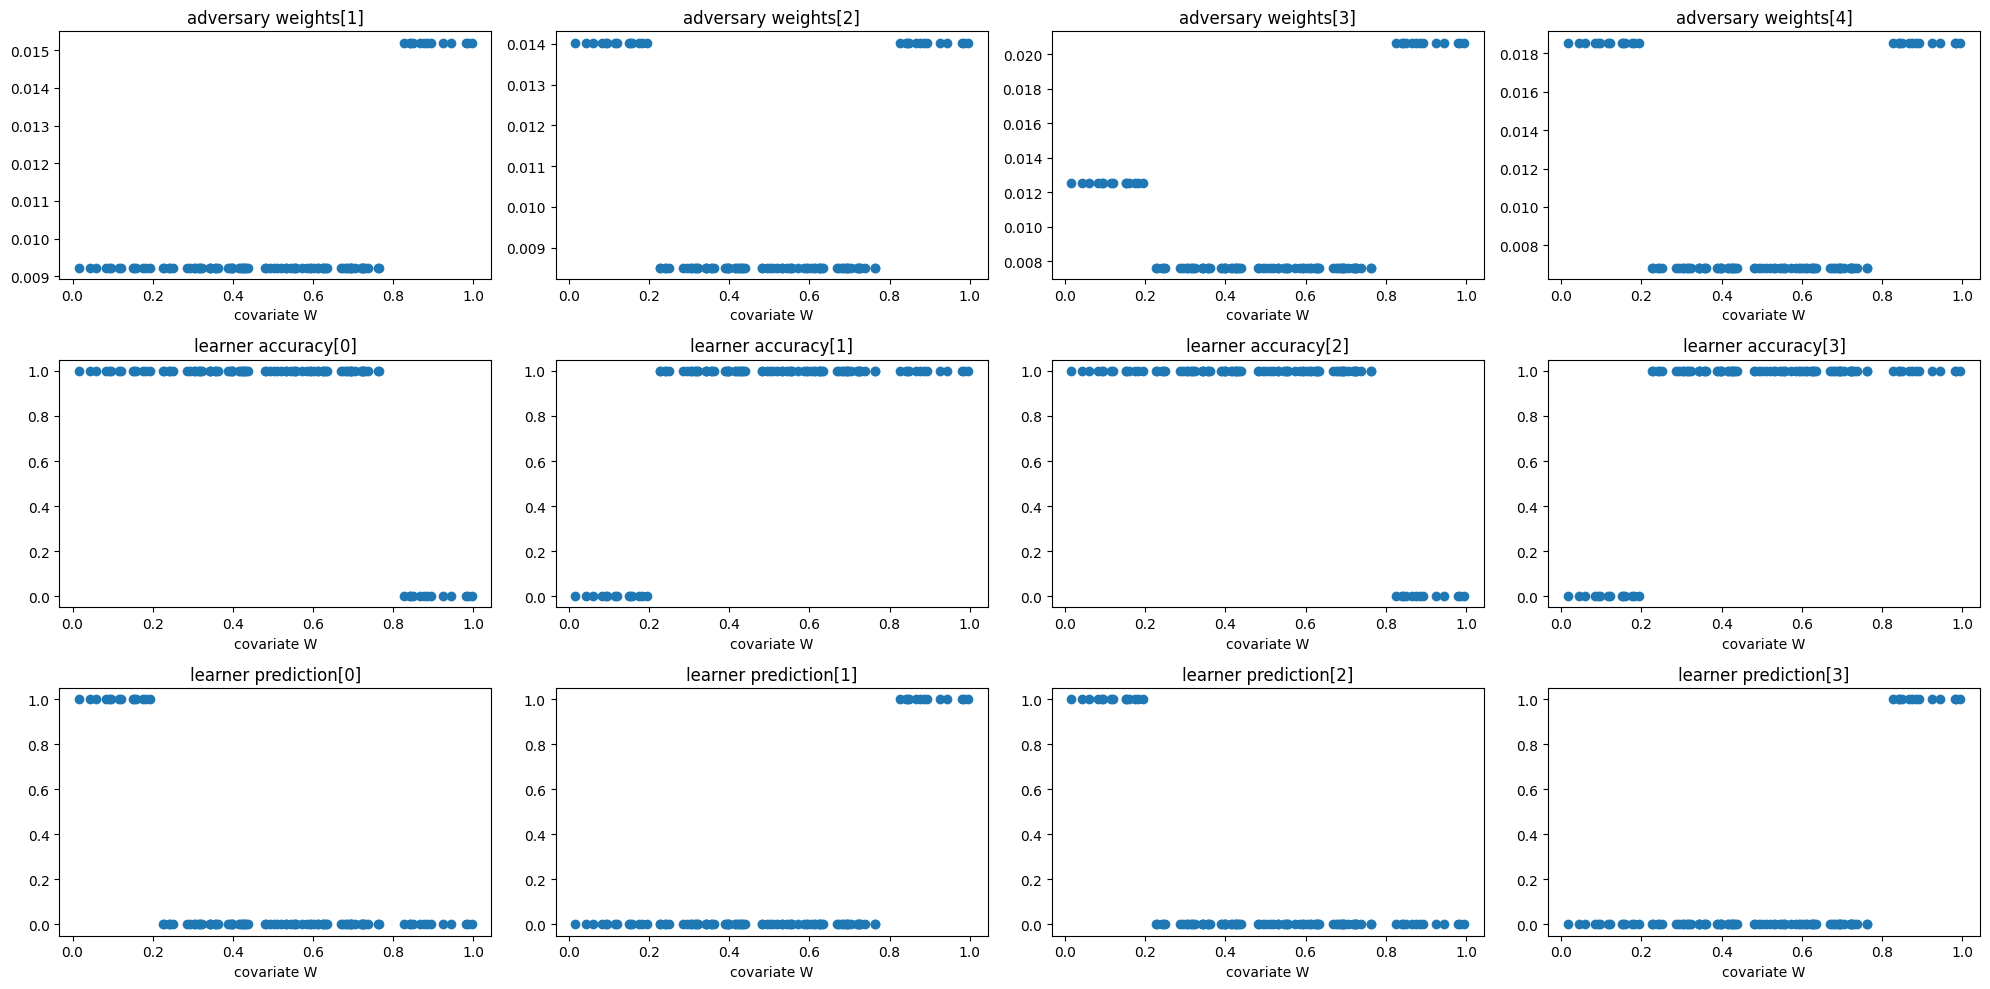 \\

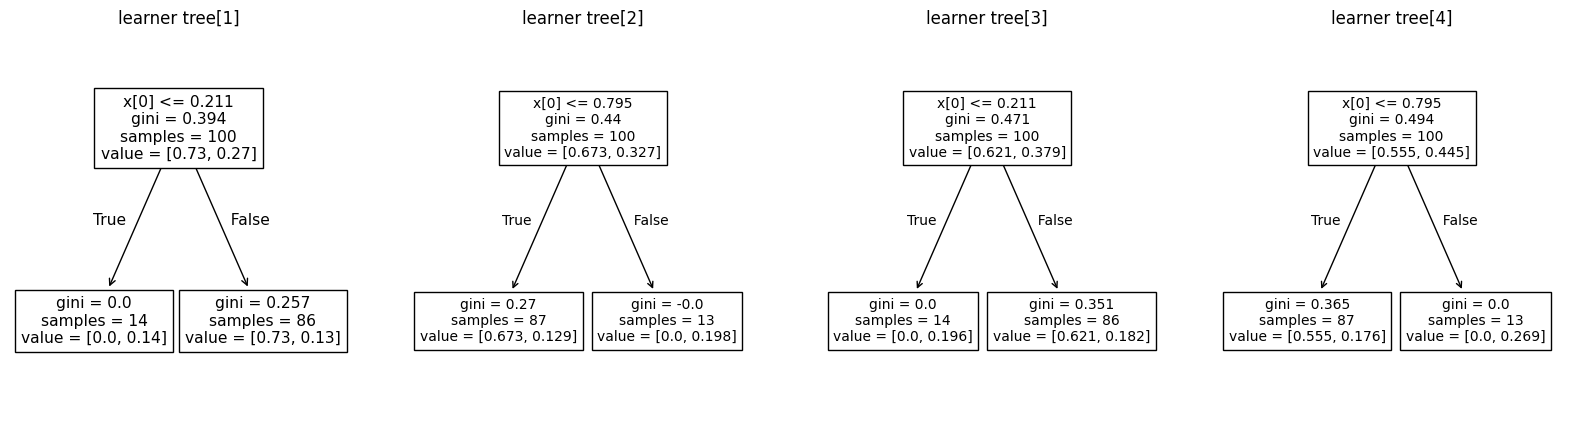

(1 point) Describe qualitatively what happened in the first few four periods of training. What weights did the adversary choose and why were they chosen? What prediction rule did the tree learn at each period and why was that prediction rule chosen? Base your answers on the form of the updates of the dynamics in the boosting algorithm.

Answer:

We know that the decision of the learner is based on a depth 1 learner tree so at the beginning, the learner can only optimize for the < 0.2 or the > 0.8 decision threshold.

We observe that at first, the adversary puts much higher weights on the sample that cannot correctly be predicted with this simple rule (the samples where W[0] > 0.8): this makes sense as the adversary wants to minimize accuracy.

Because of these higher weights, the learner focuses on this decision boundary at the next period: the learner wants to maximize accuracy where the weights are the highest.

The learner now has two trees where each predict one boundary (<0.2 or >0.8). The adversary now puts equal weights on these groups since they are predicted with similar accuracy.
